# Diabetes Stages

## 1. Problem Description

In this dataset, we are trying to predict if a person doesn't have diabetes (0), has diabetes in Stage 1 or in Stage 2. The output labels can be found in Output.csv. All the other files will be used as Input. From these files, the columns that we are interested in and what they stand for are as follows :
                          
                          SEQN : ID
                          
                          RIAGENDR : Gender
                          
                          DMDYRSUS : Years in US
                          
                          INDFMPIR : Family income
                          
                          LBXGH : GlycoHemoglobin
                          
                          BMXARMC : Arm Circum
                          
                          BMDAVSAD : Saggital Abdominal
                          
                          MGDCGSZ : Grip Strength
                          
                          DRABF : Breast fed

We will use the first 6000 samples for training while the rest for testing.

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt

## 2. Data Analysis

In [4]:
datasetx = ['demographic.csv', 'diet.csv', 'examination.csv', 'labs.csv', 'medications.csv', 'questionnaire.csv']
all_y = pd.read_csv('Output.csv')

In [5]:
demographic = pd.read_csv('demographic.csv')[['SEQN', 'RIAGENDR', 'DMDYRSUS', 'INDFMPIR']]
diet = pd.read_csv('diet.csv')[['SEQN', 'DRABF']]
exam = pd.read_csv('examination.csv')[['SEQN', 'BMXARMC', 'BMDAVSAD', 'MGDCGSZ']]
labs = pd.read_csv('labs.csv')[['SEQN', 'LBXGH']]
medications = pd.read_csv('medications.csv', encoding = 'unicode_escape')[['SEQN']]
questions = pd.read_csv('questionnaire.csv')[['SEQN']]

In [7]:
from functools import reduce
df_x = [demographic, diet, exam, labs, medications, questions]
x_merged = reduce(lambda  left,right: pd.merge(left,right,on=['SEQN'],
                                            how='inner'), df_x).drop_duplicates()

In [9]:
x_merged.rename(columns = {'SEQN': 'ID', 'RIAGENDR': 'Gender', 
                          'DMDYRSUS': 'US_Year', 'INDFMPIR': 'Fam_Income','LBXGH': 'GlycoHemgo', 
                          'BMXARMC': 'Arm_Circum', 'BMDAVSAD': 'Sag_Abd', 
                           'MGDCGSZ': 'Grip_Stre', 'DRABF': 'Breast_fed'}, inplace = True)

In [10]:
x_train, y_train = x_merged[:6000], all_y[:6000]
x_test, y_test = x_merged[6000:], all_y[6000:]

In [11]:
x_train.describe()

,ID,Gender,US_Year,Fam_Income,Breast_fed,Arm_Circum,Sag_Abd,Grip_Stre,GlycoHemgo
count,6000.000000,6000.000000,1087.000000,5570.000000,5296.000000,5693.000000,4378.000000,4641.000000,4024.000000
mean,76666.999333,1.509667,8.869365,2.225840,1.983761,28.397137,21.165875,63.010537,5.657455
std,1797.525857,0.499948,17.628441,1.637541,0.126404,8.085834,5.042025,25.087971,1.025823
min,73557.000000,1.000000,1.000000,0.000000,1.000000,10.400000,10.100000,10.900000,3.700000
25%,75107.750000,1.000000,4.000000,0.860000,2.000000,22.200000,17.300000,45.600000,5.200000
50%,76667.500000,2.000000,5.000000,1.670000,2.000000,29.200000,20.700000,60.400000,5.400000
75%,78222.250000,2.000000,7.000000,3.580000,2.000000,34.100000,24.475000,80.400000,5.800000
max,79780.000000,2.000000,99.000000,5.000000,2.000000,59.400000,40.100000,162.800000,14.700000


### 2.1. Fill in missing values

I used the following criteria to fill in data:

1. Missing Years in US - 0
2. Missing GlycoHemoglobin - median
3. Missing Saggital Abdominal - median
4. Missing Arm Circum - median
5. Missing Grip Strength - median
6. Missing Family Income - forward fill
7. Missing Breast Fed - 1
8. Missing Gender - 2 

Median value has to be calculated for the particular column only on the training set.<br>
Now create a dataframe with only the desired variables for both train and test sets. Print the training set mean, standard deviation and range again.

In [12]:
# Drop the ID columns from all train and test sets 
for df in [x_train, x_test, y_train, y_test]: 
    df.drop(columns = ['ID'], axis = 1, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
for col in x_train.columns:
    print('number of missing values in col {} is: {}'.format(col, x_train[col].isna().sum()))

number of missing values in col Gender is: 0
number of missing values in col US_Year is: 4913
number of missing values in col Fam_Income is: 430
number of missing values in col Breast_fed is: 704
number of missing values in col Arm_Circum is: 307
number of missing values in col Sag_Abd is: 1622
number of missing values in col Grip_Stre is: 1359
number of missing values in col GlycoHemgo is: 1976


In [14]:
fill_na_train = {'Gender': 2, 'US_Year': 0, 'Breast_fed': 1,
                 'Arm_Circum': x_train['Arm_Circum'].median(), 
                 'Sag_Abd': x_train['Sag_Abd'].median(), 
                 'Grip_Stre': x_train['Grip_Stre'].median(), 
                 'GlycoHemgo': x_train['GlycoHemgo'].median()}

In [15]:
x_train['Fam_Income'].fillna(method = 'ffill', inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
for column in fill_na_train.keys():
    x_train[column].fillna(fill_na_train[column], inplace = True)

In [17]:
for col in x_test.columns:
    print('number of missing values in col {} is: {}'.format(col, x_test[col].isna().sum()))

number of missing values in col Gender is: 0
number of missing values in col US_Year is: 3048
number of missing values in col Fam_Income is: 300
number of missing values in col Breast_fed is: 448
number of missing values in col Arm_Circum is: 205
number of missing values in col Sag_Abd is: 973
number of missing values in col Grip_Stre is: 777
number of missing values in col GlycoHemgo is: 1194


In [18]:
x_test['Fam_Income'].fillna(method = 'ffill', inplace = True)
for column in fill_na_train.keys():
    x_test[column].fillna(fill_na_train[column], inplace = True)

## 2.2. Data Loader

In [19]:
class DiabetesDataset(torch.utils.data.Dataset):
        
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, idx):
        'Generates one sample of data'
        return Variable(torch.from_numpy(np.array(x_train.iloc[idx, ]))), \
                Variable(torch.LongTensor(y_train.iloc[idx, ]))

In [20]:
def load_data(xdata, ydata):
    
    return xdata.as_matrix().astype(float), ydata.as_matrix().astype(float)

In [21]:
xtrain, ytrain = load_data(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# 3. Modeling

In [22]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [23]:
class MLPNet(nn.Module): 
    def __init__(self): 
        super(MLPNet, self).__init__()
        # The first hidden layer takes in output with dimension 8 (8 columns), and hidden size 1000
        #fc1: Linear(in_features = 8, out_features = 1000)
        self.fc1 = nn.Linear(8, 1000)
        # The second hidden layer takes in the last layer size 1000, and this hidden layer with size 300
        #fc2: Linear(in_features = 1000, out_features = 300)
        self.fc2 = nn.Linear(1000, 300)
        # fc3: Linear(in_features = 300, out_features = 3)
        self.fc3 = nn.Linear (300, 3)
        
    def forward (self, x):
        x = x.contiguous().view(-1, 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [24]:
model = MLPNet().double()

In [27]:
print('Number of trainable parameters: {}'.format(len(list(model.parameters()))))

Number of trainable parameters: 6


## 3.1. Training

Train your model and the rest of the script required to run this.<br>
Plot the average loss per epoch for 100 epochs. Report the loss values at epoch 100.<br>
Parameters to be used are as follows:<br>

Optimizer : Stochastic Gradient Descent<br>
Learning Rate : 1e-4<br>
Loss : Cross Entropy<br>
Batchsize : 200<br>
Shuffle : True

In [28]:
model = MLPNet().double()
optimizer = optim.SGD(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

# Parameters
params = {'batch_size': 200,
          'shuffle': True}
max_epochs = 100

training_set = DiabetesDataset(x_train, y_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

In [29]:
losslist_train = []
for epoch in range(max_epochs):
    sum_loss = 0
    # Training
    for x, y in training_generator:
        for idx in range(len(x)):
            optimizer.zero_grad()
            x_input = x[idx]
            y_target = y[idx]
            out = model(x_input)
            y_pred = out.data.numpy().ravel()[2]
            loss = criterion(out, y_target)
            sum_loss += loss.data.numpy().ravel()[0]
            loss.backward()
            optimizer.step()
    print("Epoch {} loss = {}".format(epoch, sum_loss / len(x_train)))
    losslist_train.append(sum_loss / len(x_train))

Epoch 0 loss = 0.5786005262541454
Epoch 1 loss = 0.5012193636745299
Epoch 2 loss = 0.48126790392524366
Epoch 3 loss = 0.47066346162302225
Epoch 4 loss = 0.4613761233112618
Epoch 5 loss = 0.44936404108138195
Epoch 6 loss = 0.4383986992547295
Epoch 7 loss = 0.4309733240622817
Epoch 8 loss = 0.42436768730613283
Epoch 9 loss = 0.41534205932740775
Epoch 10 loss = 0.4098040115466345
Epoch 11 loss = 0.40509507839830755
Epoch 12 loss = 0.39445905949721904
Epoch 13 loss = 0.3914035025697257
Epoch 14 loss = 0.3852914069825302
Epoch 15 loss = 0.3793183510819951
Epoch 16 loss = 0.37613165246474256
Epoch 17 loss = 0.3714570419603677
Epoch 18 loss = 0.3713850850689729
Epoch 19 loss = 0.36669639612975236
Epoch 20 loss = 0.3601824241393106
Epoch 21 loss = 0.36098794998809375
Epoch 22 loss = 0.359639436584754
Epoch 23 loss = 0.3561721337706218
Epoch 24 loss = 0.3516042311993223
Epoch 25 loss = 0.3485100466759045
Epoch 26 loss = 0.3449466663819613
Epoch 27 loss = 0.34517337877510934
Epoch 28 loss = 0.34

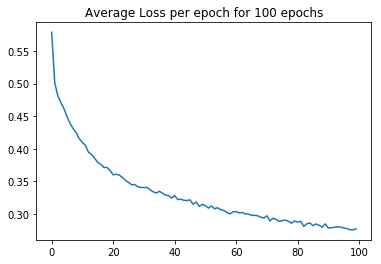

In [30]:
plt.plot(losslist_train)
plt.title('Average Loss per epoch for 100 epochs')
plt.show()

## 3.2. Testing

In [31]:
test_set = DiabetesDataset(x_test, y_test)
test_generator = torch.utils.data.DataLoader(test_set, **params)
losslist_test = []
sum_loss = 0
sum_correct = 0
# Testing

confusion_dict = {0: {0: 0, 1: 0, 2: 0},
                  1: {0: 0, 1: 0, 2: 0},
                  2: {0: 0, 1: 0, 2: 0},
                 }

y_test = []
y_predtest = []

for x, y in test_generator:
    for idx in range(len(x)):
        x_input = x[idx]
        y_target = y[idx]
        out = model(x_input)
        y_pred = out.data.numpy().ravel()[2]
        loss = criterion(out, y_target)
        sum_loss += loss.data.numpy().ravel()[0]
        pred_class = out.data.max(1, keepdim=True)[1]
        sum_correct += int(pred_class.eq(y_target))
        confusion_dict[int(y_target)][int(pred_class)] += 1
        y_test.append(int(y_target))
        y_predtest.append(y_pred)
print("Test loss = {}".format(sum_loss / len(x_train)))
print("Test accuracy = {}".format(float(sum_correct) / len(x_train)))
losslist_test.append(sum_loss / len(x_test))

Test loss = 0.1790792994055298
Test accuracy = 0.5791666666666667


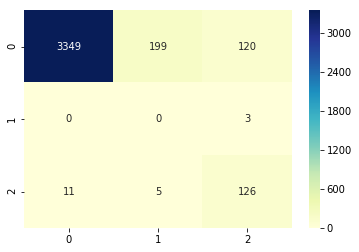

In [32]:
pd.DataFrame(confusion_dict)
import seaborn as sns
ax = sns.heatmap(pd.DataFrame(confusion_dict), annot = True, cmap = "YlGnBu", fmt='d')

## 4. Evaluation

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [44]:
y_predtest

[-3.8935558018747467,
 -3.6366187969600263,
 -1.0112664958979847,
 -2.1651162200444407,
 -1.8967734578133206,
 -2.0486545152132747,
 -5.443051980286257,
 -1.6066157771783125,
 -2.93434552930646,
 -2.214168520182383,
 -4.402662163579373,
 -2.9319936659906265,
 -2.5728153306812414,
 -4.034847353602509,
 -4.807809232047141,
 -1.2125828685159514,
 -1.8680647325186452,
 -3.750371484356437,
 -0.7668683243289409,
 -1.3714706852336467,
 -5.40979458713388,
 -4.064867683911799,
 -3.1512612831362348,
 -3.5338812381916394,
 -3.6793692638974513,
 -2.3616076504459365,
 -2.9768554726783827,
 -5.038939992346042,
 -3.0920792149218514,
 -3.7211299175430312,
 -1.8989712647588508,
 -3.881122823068679,
 3.7606916794075045,
 -5.469180616416298,
 -4.078596552081173,
 -4.993164573397257,
 -1.5269768987384973,
 -3.463751384228422,
 -2.7096876615586587,
 -4.588585237403584,
 -6.617260099618794,
 -2.5732616997916478,
 -4.416209769329817,
 3.6158062749745645,
 -3.783985371647732,
 -2.280311718312586,
 -4.54443894

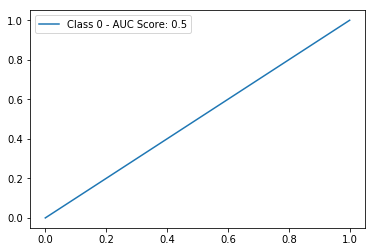

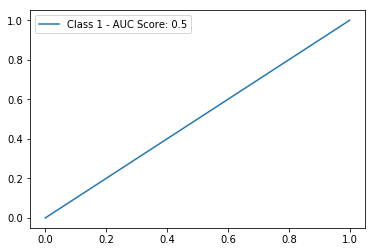

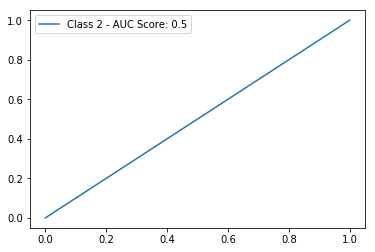

In [42]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_true = torch.Tensor(y_test).cpu().numpy()
y_pred = torch.Tensor(y_predtest).cpu().numpy()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = 'Class {} - AUC Score: {}'.format(i, roc_auc[i]))
    plt.legend()
    plt.show()

In [1]:
# for label in range(3):
#     print("AUC for label {} = {}".format(label, 
#         roc_auc_score(y_true=[y == label for y in y_test], y_score=y_predtest)))